In [37]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.sparse.linalg import norm

In [38]:
import sys
sys.path.insert(0, "../scripts")

from SZFW_lasso import *
from DZFW_lasso import *
from IZFW_lasso import *

## Load data: Covtype Dataset

In [39]:
# load data
X, y = datasets.load_svmlight_file("../Data/covtype.libsvm.binary.scale.bz2")

In [40]:
# space dimension
d = X.shape[1]
n = y.shape[0]
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")

Space Dimensions
d: 54
n: 581012


In [41]:
# define the objective function
F = lambda w: 0.5/n * np.sum(np.power(y - X @ w, 2))

In [42]:
# initialize prarameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

# starting point: center
indeces = np.random.randint(low = 0, high = d-1, size = 20)
w0[indeces] = int(0)
w0 = np.zeros(d)
print(f"w0: {w0}")

w0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]


## Deterministic Gradient Free Frank Wolfe on Covtype

In [43]:
%%time

# Lipschitz constant 
L = 3

fpred, f, w, mean, t, loss, f_values = detZFW(F, L, d, w0, T=5)

Loss evaluation at time 1:	0.7013836

Loss evaluation at time 2:	0.1212442

Loss evaluation at time 3:	0.0424383

Loss evaluation at time 4:	0.0199207

Loss evaluation at time 5:	0.0109946

CPU times: user 16.5 s, sys: 661 ms, total: 17.1 s
Wall time: 10.2 s


In [44]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.34641199738781203

F(w) = 0.3354173784042209

w = [0.         0.         0.         0.         0.         0.
 0.         0.95238095 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.        ]

average w = [0.         0.         0.         0.         0.         0.
 0.         0.85714286 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

In [45]:
lossd = np.load("../Data/results/loss_dZFW_lasso.npy") # data from colab (NOT NORMALIZED)
f_d = np.load("../Data/results/function_dZFW_lasso.npy")
f_d = f_d/n
f_star = np.min(f_d)
lossd = lossd/n

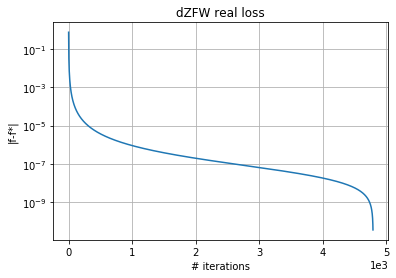

In [46]:
F_evald = np.abs(f_d - f_star)
F_evald = F_evald[:-2]
plt.plot(F_evald)
plt.yscale("log")
plt.title("dZFW real loss")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/dZFW_real_loss", dpi=400)

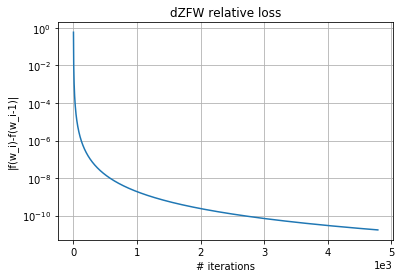

In [47]:
plt.plot(lossd)
plt.yscale("log")
plt.title("dZFW relative loss")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/dZFW_relative_loss", dpi=400)

## Stochastic Gradient Free Frank Wolfe on Covtype

In [48]:
%%time
fpred, f, w, mean, t, loss, f_values = stochasticZFW(F, d, w0, method = "IRDSA1", r=1, T=10, eps=1e-10)

Loss evaluation at time 1:	0.0275749

Loss evaluation at time 2:	0.0056888

Loss evaluation at time 3:	0.2195518

Loss evaluation at time 4:	0.0789956

Loss evaluation at time 5:	0.0358417

Loss evaluation at time 6:	0.1041304

Loss evaluation at time 7:	0.0282238

Loss evaluation at time 8:	0.0458985

Loss evaluation at time 9:	0.0664736

Loss evaluation at time 10:	0.0526058

CPU times: user 4.87 s, sys: 287 ms, total: 5.15 s
Wall time: 3.55 s


In [49]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w0) = 1.2313988351359353

F(w_pred) = 0.722194251100365

F(w) = 0.6695884777393749

w = [ 0.16339869  0.07843137  0.          0.          0.          0.
  0.21568627  0.1503268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09803922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.05228758  0.          0.          0.         -0.05882353  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]

average w = [ 0.12222222  0.06666667  0.          0.          0.          0.
  0.03333333  0.14444444  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03333333
  0.          0.  

In [50]:
loss_stochm6 = np.load("../Data/results/loss_SZFWm6_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm6 = np.load("../Data/results/function_SZFWm6_lasso.npy")
f_stochm6 = f_stochm6/n

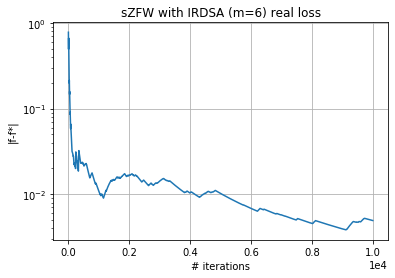

In [51]:
F_evalsm6 = np.abs(f_stochm6 - f_star)
plt.plot(F_evalsm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6) real loss")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/sZFW_IRDSAm6_real_loss", dpi=400)

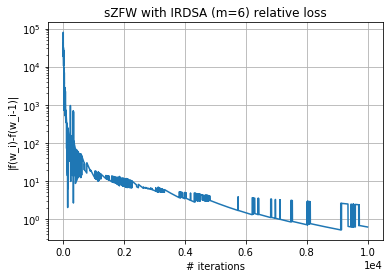

In [52]:
plt.plot(loss_stochm6)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=6) relative loss")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/sZFW_IRDSAm6_relative_loss", dpi=400)

In [53]:
loss_stochm1 = np.load("../Data/results/loss_SZFWm1_lasso.npy") # data from colab (NOT NORMALIZED)
f_stochm1 = np.load("../Data/results/function_SZFWm1_lasso.npy")
f_stochm1 = f_stochm1/n

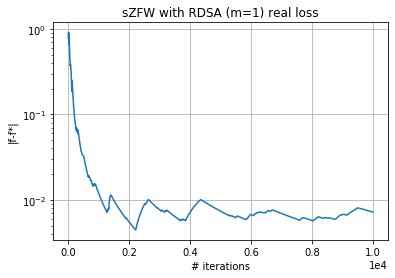

In [54]:
F_evalsm1 = np.abs(f_stochm1 - f_star)
plt.plot(F_evalsm1)
plt.yscale("log")
plt.title("sZFW with RDSA (m=1) real loss")
plt.xlabel("# iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f-f*|")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/sZFW_IRDSAm1_real_loss", dpi=400)

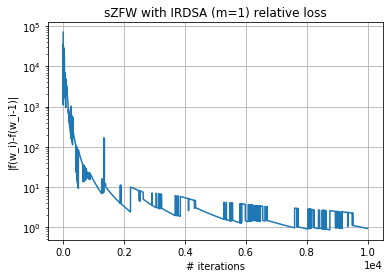

In [55]:
plt.plot(loss_stochm1)
plt.yscale("log")
plt.title("sZFW with IRDSA (m=1) relative loss")
plt.xlabel("# iterations")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/sZFW_IRDSAm1_relative_loss", dpi=400)

## Zeroth order stochastic accelerated gradient method with Inexact updates on Covtype

In [56]:
# setting parameters
L = 3
D = 20 # we will start from m = 6, up to T * (T+1) / D * (d+3) = 28785 (for T=100) m> d
#D = 10000 # m < d
B = 1

In [ ]:
%%time 

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 100, eps = 1e-8)

Loss evaluation at time 1:	0.2841402

Loss evaluation at time 2:	0.2480290

Loss evaluation at time 3:	0.1184176

Loss evaluation at time 4:	0.0764265

Loss evaluation at time 5:	0.0481458



In [ ]:
np.save('../Data/results/function_IZFW_lasso_long.npy', f_values) # data from cluster
np.save('../Data/results/loss_IZFW_lasso_long.npy', loss)
np.save('../Data/results/inner_IZFW_lasso_long.npy', inner)

In [22]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

OUTPUT:

F(w_pred) = 0.722194251100365

F(w) = 0.6695884777393749

w = [ 0.16339869  0.07843137  0.          0.          0.          0.
  0.21568627  0.1503268   0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.09803922
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.05228758  0.          0.          0.         -0.05882353  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ]

average w = [ 0.12222222  0.06666667  0.          0.          0.          0.
  0.03333333  0.14444444  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.03333333
  0.          0.          0.          0.      

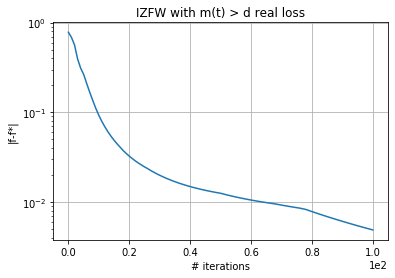

In [21]:
f_inex = np.load('../Data/results/function_IZFW_lasso_long.npy') # data from cluster
loss_inex = np.load('../Data/results/loss_IZFW_lasso_long.npy')
inner_inex = np.load('../Data/results/inner_IZFW_lasso_long.npy')
F_eval_inex = np.abs(f_inex - f_star)
plt.plot(F_eval_inex)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) > d real loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/IZFW_IRDSA_real_loss", dpi=400)

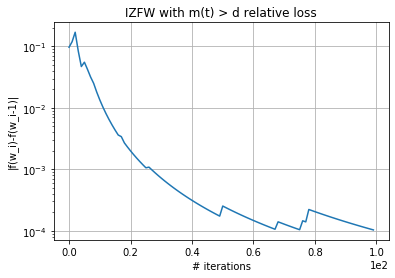

In [22]:
plt.plot(loss_inex)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) > d relative loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/IZFW_IRDSA_relative_loss", dpi=400)

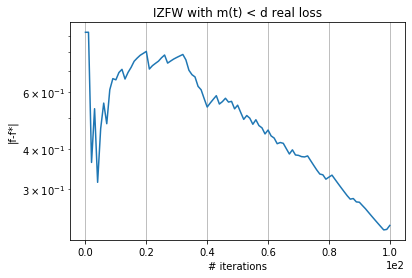

In [23]:
f_inex_mind = np.load('../Data/results/function_IZFW_lasso_mind.npy') # data from cluster
loss_inex_mind = np.load('../Data/results/loss_IZFW_lasso_mind.npy')
inner_inex_mind = np.load('../Data/results/inner_IZFW_lasso_mind.npy')
F_eval_inex_mind = np.abs(f_inex_mind - f_star)
plt.plot(F_eval_inex_mind)
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) < d real loss")
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/IZFW_IRDSA_mind_real_loss", dpi=400)

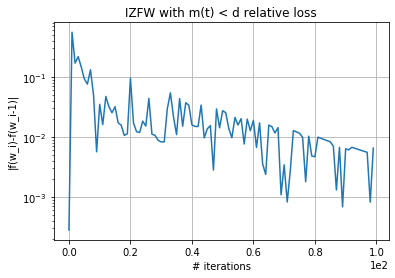

In [25]:
plt.plot(loss_inex_mind)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) < d relative loss")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/IZFW_IRDSA_mind_relative_loss", dpi=400)

## Result Comparison on Covtype


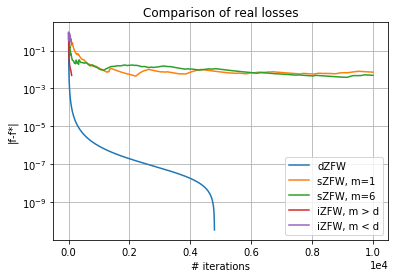

In [27]:
plt.plot(F_evald)
plt.plot(F_evalsm1)
plt.plot(F_evalsm6)
plt.plot(F_eval_inex)
plt.plot(F_eval_inex_mind)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, m > d", "iZFW, m < d"))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/Comparison_real_losses_iteration", dpi=400)

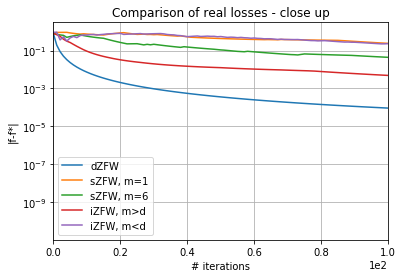

In [28]:
plt.plot(F_evald)
plt.plot(F_evalsm1)
plt.plot(F_evalsm6)
plt.plot(F_eval_inex)
plt.plot(F_eval_inex_mind)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.xlim((0, 100))
plt.title("Comparison of real losses - close up")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, m>d", "iZFW, m<d"))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/Comparison_real_losses_iteration_closeup", dpi=400)

In [28]:
m = lambda t: t * (t+1) / 20 * (54+3)
m(101) 

29360.7

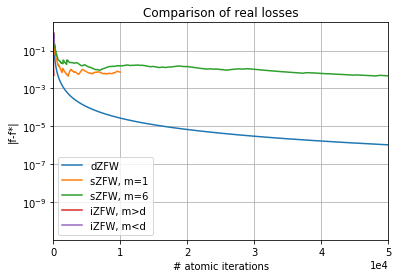

In [29]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, len(F_evald)*d, d), F_evald)
plt.plot(range(0, len(F_evalsm1)*1, 1), F_evalsm1)
plt.plot(range(0, len(F_evalsm6)*6, 6), F_evalsm6)
plt.plot([m(t)+inner_inex[t] for t in range(101)], F_eval_inex)
plt.plot([m(t)+inner_inex_mind[t] for t in range(101)], F_eval_inex_mind)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, m>d", "iZFW, m<d"))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.xlim((0,50000))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/Comparison_real_losses_atomic", dpi=400)

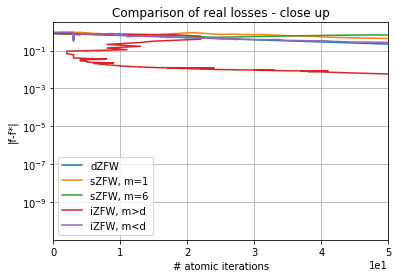

In [36]:
plt.plot(range(1, len(F_evald)*d, d), F_evald)
plt.plot(range(0, len(F_evalsm1)*1, 1), F_evalsm1)
plt.plot(range(0, len(F_evalsm6)*6, 6), F_evalsm6)
plt.plot([np.ceil(m(t))+inner_inex[t] for t in range(101)], F_eval_inex)
plt.plot([np.ceil(m(t))+inner_inex_mind[t] for t in range(101)], F_eval_inex_mind)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, m>d", "iZFW, m<d"))
plt.yscale("log")
plt.title("Comparison of real losses - close up")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.xlim((0,50))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/Comparison_real_losses_atomic_closeup", dpi=400)

In [31]:
inner_inex

array([ 0, 17, 21, 21, 14, 12,  7, 12,  7, 10,  1,  1,  1,  1,  1,  1,  1,
        1,  4,  5,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        8,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  5,  1,  1,  1,  1,  1,  1,  1,  6,  1,  2,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [33]:
inner_inex_mind


array([0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2])

# Load data: artificial dataset


In [ ]:
def CreateDataSet(n, d, s):
    """
    n rows, d features, s sparsity level
    """
    np.random.seed(1007)
    s = np.int(d * s)
    X = np.random.randn(n,d) 
    pn = int(s/2)
    w_s = np.concatenate((np.ones(pn), -np.ones(pn), np.zeros(d-2*pn)))
    w_s = w_s/np.sum(np.abs(w_s))
    epsilon = 0.01*np.random.rand(n) # noise
    y = X @ w_s + epsilon
    return X, y, w_s, epsilon

In [ ]:
X, y, w_star, noise = CreateDataSet(n = 100, d = 1000, s = 0.05)

In [ ]:
np.sum(np.abs(w_star))

In [ ]:
# space dimension
d = X.shape[1]
n = y.shape[0]
f_star = F(w_star)
print(f"Space Dimensions\nd: {d}")
print(f"n: {y.shape[0]}")
print(f"f* = {f_star:.8f}")

In [ ]:
# initialize parameters for the algorithm (in common for all the algorithms)

# stating point, sparse
np.random.seed(1007)
w0 = np.random.rand(d)
w0 = w0/np.sum(w0) * np.random.rand(1)

# starting point: center
indeces = np.random.randint(low = 0, high = d-1, size = int(d/2))
w0[indeces] = int(0)
print(f"w0: {w0[:10]}, {np.count_nonzero(w0)} elements different from zero")

## Deterministic Gradient Free Frank Wolfe on Artificial Dataset

In [ ]:
# Lipshitz constant 
L = 2/X.shape[0] * np.linalg.norm(X.T @ X)
print(L)

In [ ]:
%%time

# Lipschitz constant 

fpred, f, w, mean, t, loss, f_valuesd = detZFW(F, L, d, w0, T=1000, eps = 1e-8)

In [ ]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

In [ ]:
loss_ad = np.load("../Data/results/loss_dZFW_lasso_AD.npy")
f_valuesd = np.load("../Data/results/function_dZFW_lasso_AD.npy")

In [ ]:
plt.plot(loss_ad)
plt.yscale("log")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.title("DZFW relative losses")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/dZFW_relative_loss", dpi=400)

In [ ]:
plt.plot(f_valuesd - f_star)
plt.yscale("log")
plt.title("DZFW real losses")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Covtype/dZFW_real_loss", dpi=400)

## Stochastic Gradient Free Frank Wolfe on Artificial Dataset

In [ ]:
%%time
fpred, f, w, mean, t, lossm1ad, f_valuessm1ad = stochasticZFW(F, d, w0, method = "RDSA", r=1, T=10000, eps=1e-8)

In [ ]:
plt.plot(lossm1ad)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.title("sZFW with IRDA (m=1) relative loss")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/sZFW_IRDSAm1_relative_loss", dpi=400)

In [ ]:
plt.plot(f_valuessm1ad - f_star)
plt.yscale("log")
plt.title("sZFW with IRDA (m=1) real loss")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/sZFW_IRDSAm1_real_loss", dpi=400)

In [ ]:
%%time
fpred, f, w, mean, t, loss, f_valuess = stochasticZFW(F, d, w0, method = "IRDSA2", r=1, T=1000, eps=1e-8)

In [ ]:
print(f'OUTPUT:\n\nF(w0) = {F(w0)}\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

In [ ]:
loss_sad = np.load("../Data/results/loss_SZFW_lasso_AD.npy")
f_valuess = np.load("../Data/results/function_SZFW_lasso_AD.npy")

In [ ]:
plt.plot(loss_sad)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.title("sZFW with IRDA (m=6) relative loss")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/sZFW_IRDSAm6_relative_loss", dpi=400)

In [ ]:
plt.plot(f_valuess - f_star)
plt.yscale("log")
plt.title("sZFW with IRDA (m=6) real loss")
plt.ylabel("|f-f*|")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/sZFW_IRDSAm6_real_loss", dpi=400)

## Zeroth order stochastic accelerated gradient method with Inexact updates on Artificial Dataset

In [ ]:
# setting parameters: UPDATE WITH THE FINAL ONES
B = 1 
L = 0.1
D = 10000

In [ ]:
%%time 

fpred, f, w, mean, t, loss, f_values, inner = IZFW(F, d, w0, L, B, r = 1, T = 5, eps = 1e-8)


'''
with max iter = 100, m(101) = 1034

F(w_pred) = 0.01524209692890398

F(w) = 0.01502719283827

w = ***too long***

average w = ***too long***

T = 100
0.009651865274889974 0.01502719283827

--------------------------------------

with max iter = 1000, m(1001) = 100602

***Add .res***
'''

In [ ]:
loss_i = np.load("../Data/results/loss_IZFW_AD_long.npy")
f_i = np.load("../Data/results/function_IZFW_AD_long.npy")
inner_i = np.load("../Data/results/inner_IZFW_AD_long.npy")

In [ ]:
print(f'OUTPUT:\n\nF(w_pred) = {fpred}\n\nF(w) = {f}\n\nw = {w}\n\naverage w = {mean}\n\nT = {t}')

In [ ]:
F_eval_i = np.abs(f_i - f_star)
plt.plot(F_eval_i)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) < d real loss")
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Artificialdataset/IZFW_IRDSA_real_loss", dpi=400)

In [ ]:
plt.plot(loss_i)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) < d relative loss")
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Artificialdataset/IZFW_IRDSA_relative_loss", dpi=400)

In [ ]:
loss_i1000 = np.load("../Data/results/loss_IZFW_AD_long_1000.npy")
f_i1000 = np.load("../Data/results/function_IZFW_AD_long_1000.npy")
inner_i1000 = np.load("../Data/results/inner_IZFW_AD_long_1000.npy")

In [ ]:
F_eval_i1000 = np.abs(f_i1000 - f_star)
plt.plot(F_eval_i1000)
plt.yscale("log")
plt.ylabel("|f-f*|")
plt.title("IZFW with m(t) > d real loss")
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Artificialdataset/IZFW_IRDSA1000_real_loss", dpi=400)

In [ ]:
plt.plot(loss_i1000)
plt.yscale("log")
plt.ylabel("|f(w_i)-f(w_i-1)|")
plt.title("IZFW with m(t) > d relative loss")
plt.xlabel("# iterations")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/Artificialdataset/IZFW_IRDSA1000_relative_loss", dpi=400)

## Comparisons among all methods on Artificial Dataset

In [ ]:
F_d = np.abs(f_valuesd - f_star)
F_sm1 = np.abs(f_valuessm1ad - f_star)
F_s = np.abs(f_valuess - f_star)
F_i = np.abs(f_i - f_star)
F_i1000 = np.abs(f_i1000 - f_star)
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses")
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, t=100", "iZFW, t=1000"))
plt.xlabel('# iterations')
plt.ylabel('|f-f*|')
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_iteration", dpi=400)

In [ ]:
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses - close up 1")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.xlim((0,1000))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, t=100", "iZFW, t=1000"), loc = "upper right")
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_iteration_closeup1", dpi=400)

In [ ]:
plt.plot(F_d)
plt.plot(F_sm1)
plt.plot(F_s)
plt.plot(F_i)
plt.plot(F_i1000)
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.yscale("log")
plt.title("Comparison of real losses - close up 2")
plt.xlabel("# iterations")
plt.ylabel("|f-f*|")
plt.xlim((0,100))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", "iZFW, t=100", "iZFW, t=1000"))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_iteration_closeup2", dpi=400)

In [ ]:
m = lambda t: t * (t+1) / D * (d+3)

plt.plot(range(1, 251*d, d), F_d)
plt.plot(range(len(F_sm1)),F_sm1)
plt.plot(range(0, 750*100+1, 100), F_s)
plt.plot([m(t)+inner_i[t] for t in range(101)], F_i)
plt.plot([m(t)+inner_i1000[t] for t in range(len(inner_i1000))], f_i1000 - f_star)
plt.yscale("log")
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", 'iZFW, t=100','iZFW, t=1000'))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_atomic", dpi=400)

In [ ]:
plt.plot(range(1, 251*d, d), F_d)
plt.plot(range(len(F_sm1)),F_sm1)
plt.plot(range(0, 750*100+1, 100), F_s)
plt.plot([m(t)+inner_i[t] for t in range(101)], F_i)
plt.plot([m(t)+inner_i1000[t] for t in range(len(inner_i1000))], f_i1000 - f_star)
plt.yscale("log")
plt.xlim((0, 1000))
plt.title("Comparison of real losses")
plt.ylabel("|f-f*|")
plt.xlabel("# atomic iterations")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.legend(('dZFW', 'sZFW, m=1', "sZFW, m=6", 'iZFW, t=100','iZFW, t=1000'))
plt.grid()
plt.savefig("../Figures_Lasso_Problem/ArtificialDataset/Comparison_real_losses_atomic_closeup", dpi=400)